In [1]:
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import os, sys
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# find root directory and add to path
root_index = os.getcwd().rfind('notebooks')
root_directory = os.path.dirname(os.getcwd()[:root_index])
sys.path.append(root_directory)

from MotorNet.plants.skeletons import Arm
from MotorNet.utils.plotor import plot_pos_over_time
from MotorNet.utils.plotOpenSim import plotOpenSim
from MotorNet.nets.losses import empty_loss, position_loss, activation_squared_loss
from MotorNet.nets.layers import GRUController
from MotorNet.nets.callbacks import BatchLogger
from mpl_toolkits.mplot3d import Axes3D
%load_ext autoreload
%autoreload 2

# tf.debugging.enable_check_numerics()
print('tensorflow version: ' + tf.__version__)

tensorflow version: 2.4.1


simulation duration: 0.8062179269909393 sec


<tf.Tensor: shape=(441, 4), dtype=float32, numpy=
array([[-0.08844888,  0.19672546,  0.24662545,  3.1207778 ],
       [-0.08634293,  0.1282287 ,  0.2627156 ,  3.1189196 ],
       [-0.07648414,  0.06107692,  0.28808567,  3.130809  ],
       ...,
       [-0.04707891,  0.08695944,  0.3595806 ,  0.5826496 ],
       [-0.05918251,  0.10340871,  0.40755385,  0.7326957 ],
       [-0.07481796,  0.12395777,  0.46738926,  0.9397286 ]],
      dtype=float32)>

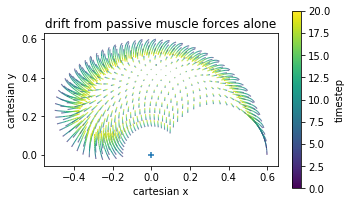

In [2]:

arm = Arm()

sho, elb = np.meshgrid(
    np.linspace(arm.pos_lower_bounds[0], arm.pos_upper_bounds[0], 21).astype('float32'),
    np.linspace(arm.pos_lower_bounds[1], arm.pos_upper_bounds[1], 21).astype('float32'))
z = tf.zeros_like(sho.reshape(-1))

ex = tf.zeros((sho.size, arm.n_muscles)) * [0, 0, 0, 0, 0, 0]
state0 = arm.get_initial_states(initial_joint_state=tf.stack([sho.reshape(-1), elb.reshape(-1), z, z], axis=1))
c_results = state0[1][:, tf.newaxis, :]
states = state0

start = time.monotonic()
# 200 ms simulation to assess drift
for _ in range(int(0.2 / arm.dt)):
    states = arm(ex, states[0], states[-1])
    c_results = tf.concat([c_results, states[1][:, tf.newaxis, :]], axis=1)
print('simulation duration: ' + str(time.monotonic() - start) + ' sec')

plt.figure(figsize=(5, 3)).set_tight_layout(True)
plot_pos_over_time(cart_results=c_results)
plt.title('drift from passive muscle forces alone')


states[1] - state0[1]

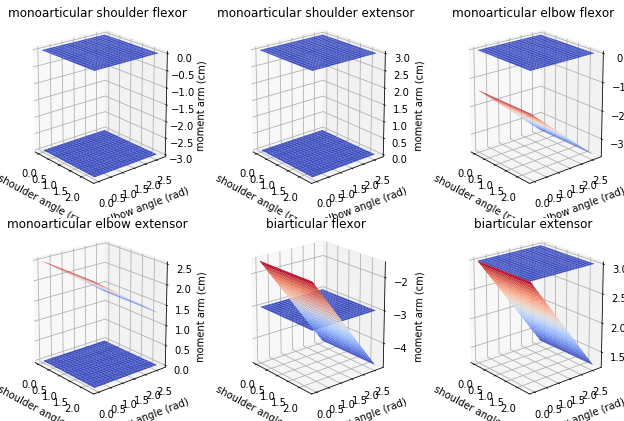

In [3]:
mstate = state0[-1].numpy().reshape((21, 21, 5, 6))
muscles = ['monoarticular shoulder flexor',
           'monoarticular shoulder extensor',
           'monoarticular elbow flexor',
           'monoarticular elbow extensor',
           'biarticular flexor',
           'biarticular extensor']

fig = plt.figure(figsize=(9, 6))
fig.set_tight_layout(True)
for m in range(6):
    ax = fig.add_subplot(2, 3, m+1, projection='3d')
    ax.plot_surface(sho, elb, mstate[:, :, 3, m] * 100, cmap=plt.get_cmap('coolwarm'))
    ax.plot_surface(sho, elb, mstate[:, :, 4, m] * 100, cmap=plt.get_cmap('coolwarm'))
    ax.set_xlabel('shoulder angle (rad)')
    ax.set_ylabel('elbow angle (rad)')
    ax.set_zlabel('moment arm (cm)')
    ax.view_init(18, -40)
    ax.locator_params(nbins=6)
    plt.title(muscles[m])
plt.show()

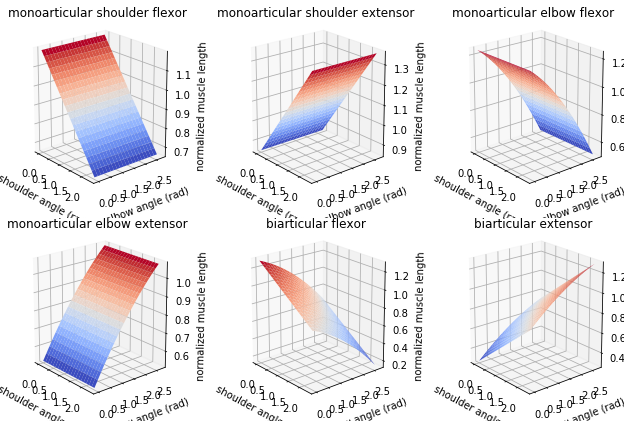

In [4]:
fig = plt.figure(figsize=(9, 6))
fig.set_tight_layout(True)
for m in range(6):
    ax = fig.add_subplot(2, 3, m+1, projection='3d')
    ax.plot_surface(sho, elb, mstate[:, :, 1, m], cmap=plt.get_cmap('coolwarm'))
    ax.set_xlabel('shoulder angle (rad)')
    ax.set_ylabel('elbow angle (rad)')
    ax.set_zlabel('normalized muscle length')
    ax.view_init(18, -40)
    ax.locator_params(nbins=6)
    plt.title(muscles[m])
plt.show()

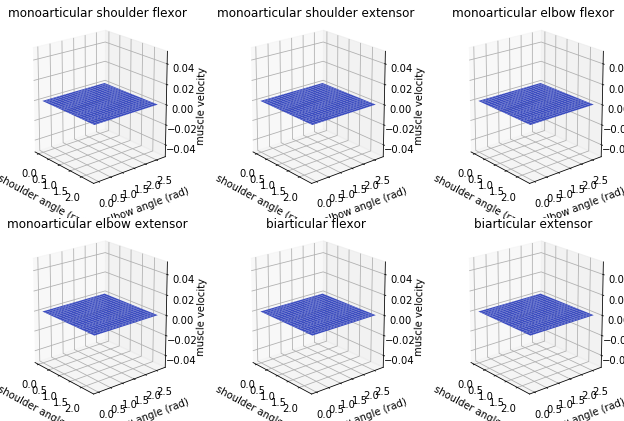

In [5]:
fig = plt.figure(figsize=(9, 6))
fig.set_tight_layout(True)
for m in range(6):
    ax = fig.add_subplot(2, 3, m+1, projection='3d')
    ax.plot_surface(sho, elb, mstate[:, :, 2, m], cmap=plt.get_cmap('coolwarm'))
    ax.set_xlabel('shoulder angle (rad)')
    ax.set_ylabel('elbow angle (rad)')
    ax.set_zlabel('muscle velocity')
    ax.view_init(18, -40)
    ax.locator_params(nbins=6)
    plt.title(muscles[m])
plt.show()



In [6]:
arm = Arm(timestep=0.001, proprioceptive_delay=0.04, visual_delay=0.13)
cell = GRUController(plant=arm, n_units=50, kernel_regularizer=10**-6, name='cell')

# declare inputs
targets = Input((None, arm.state_dim,), name='target')
state0 = [Input((arm.state_dim, ), name='joint0'),
          Input((arm.state_dim, ), name='cartesian0'),
          Input((arm.muscle_state_dim, arm.n_muscles, ), name='muscle0'),
          Input((arm.state_dim, arm.proprioceptive_delay, ), name='proprio_feedback0'),
          Input((arm.state_dim, arm.visual_delay, ), name='visual_feedback0')]
state0.extend([Input((n, ), name='gru' + str(k) + '_hidden0') for k, n in enumerate(cell.n_units)])


# wrap cell in an RNN layer
states_out = tf.keras.layers.RNN(cell=cell, return_sequences=True, name='RNN')(targets, initial_state=state0)
control_rnn = Model(inputs=[targets, state0], outputs=states_out, name='controller')


# link outputs to their loss
losses = {name: empty_loss() for name in states_out.keys()}
loss_weights = {name: 0. for name in states_out.keys()}
losses['cartesian state'] = position_loss()
losses['muscle state'] = activation_squared_loss()
loss_weights['cartesian state'] = 1
loss_weights['muscle state'] = 0.2

# and compile
control_rnn.compile(optimizer=tf.optimizers.Adam(clipnorm=1.), loss=losses, loss_weights=loss_weights)
batchlog_callback = BatchLogger()
control_rnn.summary()



Model: "controller"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
target (InputLayer)             [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
joint0 (InputLayer)             [(None, 4)]          0                                            
__________________________________________________________________________________________________
cartesian0 (InputLayer)         [(None, 4)]          0                                            
__________________________________________________________________________________________________
muscle0 (InputLayer)            [(None, 5, 6)]       0                                            
_________________________________________________________________________________________

In [7]:
name = '50gru_1e-3dt_weights'
control_rnn.load_weights(os.getcwd() + '/saved_models/' + name)

dataset_size = 10000 * 32
n_t = int(0.5 / arm.dt)

with tf.device('/cpu:0'):
    for _ in range(0):
        init_states = cell.get_initial_state(batch_size=dataset_size)
        goal_states = arm.draw_random_uniform_states(batch_size=dataset_size)
        target = arm.state2target(state=arm.joint2cartesian(goal_states), n_timesteps=n_t)
        control_rnn.fit([target, init_states], target, epochs=1, batch_size=32, verbose=1, callbacks=[batchlog_callback], shuffle=False)



In [8]:
if 'loss' in batchlog_callback.history:
    plt.plot(batchlog_callback.history['loss'])
    plt.xlabel('batch')
    plt.ylabel('loss')
    # plt.semilogy()
    plt.show()


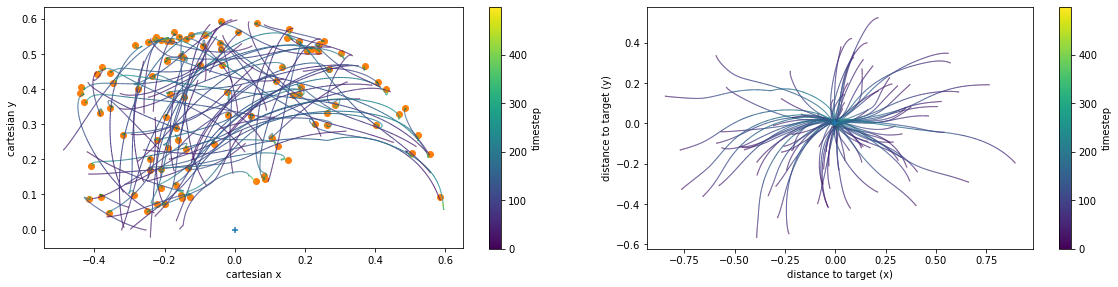

In [9]:
init_states_sample = cell.get_initial_state(batch_size=100)
goal_states = arm.draw_random_uniform_states(batch_size=100)
target_sample = arm.state2target(state=arm.joint2cartesian(goal_states), n_timesteps=n_t)

results = control_rnn([target_sample, init_states_sample], training=False)

j_results = results['joint position']
c_results = results['cartesian position']
m_results = results['muscle state']

plt.figure(figsize=(16, 4)).set_tight_layout(True)
plt.subplot(121)
plot_pos_over_time(cart_results=c_results)
plt.scatter(target_sample[:, 0, 0], target_sample[:, 0, 1])

plt.subplot(122)
plot_pos_over_time(cart_results=c_results - target_sample)
plt.xlabel('distance to target (x)')
plt.ylabel('distance to target (y)')
plt.show()

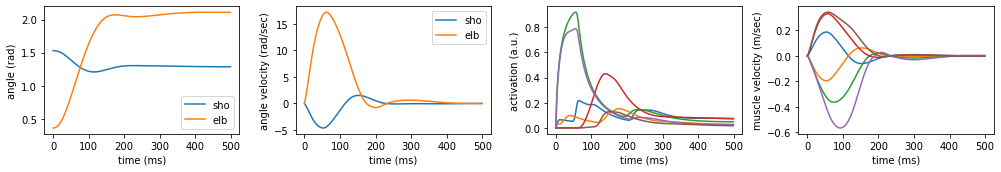

In [10]:
trial = 1
plt.figure(figsize=(14, 2.5)).set_tight_layout(True)

plt.subplot(141)
plt.plot(j_results[trial, :, 0].numpy().squeeze(), label='sho')
plt.plot(j_results[trial, :, 1].numpy().squeeze(), label='elb')
plt.legend()
plt.xlabel('time (ms)')
plt.ylabel('angle (rad)')

plt.subplot(142)
plt.plot(j_results[trial, :, 2].numpy().squeeze(), label='sho')
plt.plot(j_results[trial, :, 3].numpy().squeeze(), label='elb')
plt.legend()
plt.xlabel('time (ms)')
plt.ylabel('angle velocity (rad/sec)')

plt.subplot(143)
plt.plot(m_results[trial, :, 0, :].numpy().squeeze())
plt.xlabel('time (ms)')
plt.ylabel('activation (a.u.)')

plt.subplot(144)
plt.plot(m_results[trial, :, 2, :].numpy().squeeze())
plt.xlabel('time (ms)')
plt.ylabel('muscle velocity (m/sec)')

plt.show()


In [11]:
if len(batchlog_callback.weights_log) > 0:
    w0 = batchlog_callback.weights_log[0]
    w1 = batchlog_callback.weights_log[-1]

    fig, axs = plt.subplots(nrows=2, ncols=len(w0), sharex='col')
    fig.set_tight_layout(tight=True)
    fig.set_size_inches((15, 6))

    for n in range(len(w0)):
        weights_ini = w0[n].numpy()
        weights_fin = w1[n].numpy()

        if len(weights_ini.shape) < 10:
            axs[0,n].hist(weights_ini.flatten())
            axs[1,n].hist(weights_fin.flatten())
        else:
            axs[0,n].imshow(weights_ini, interpolation='none')
            axs[1,n].imshow(weights_fin, interpolation='none')

    plt.show()



In [12]:
### To apply a set of weights from a previous iteration weight set w1
# control_rnn.get_layer('RNN').set_weights([w.numpy() for w in w1])

### save model
# name = '50gru_1e-3dt_weights'
# control_rnn.save_weights(os.getcwd() + '/saved_models/' + name)

In [20]:

plotOpenSim(results, os.getcwd() + '/saved_models/toOpenSim')


















